# Proposed pipeline

## A) Loading the data

In [ ]:
!pip install pandas==1.0.5

In [ ]:
!pip install tld

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import bz2
import json
import csv
import copy
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup as soup
from ast import literal_eval
import urllib.request as ul
from collections import Counter
from tld import get_fld
import string
import os
import nltk
from statsmodels.stats.weightstats import DescrStatsW



nltk.download('stopwords')
nltk.download("punkt")
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('crubadan')

from nltk.sentiment import SentimentIntensityAnalyzer  # VADER is better for short sentences, but we only have this so we use just that.
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

drive = '/content/drive/MyDrive/ADA-shared/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package crubadan to /root/nltk_data...
[nltk_data]   Package crubadan is already up-to-date!


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
pd.__version__

'1.0.5'

***TBD***

In [ ]:
# Load & format quotes from 2020
path_to_file = drive + 'Quotebank/quotes-2020.json.bz2' 

list_of_quotes_dict = []
count = 0
sample_size = 10000  # Sample chosen for current experiments

# Open the 2020 quotebank
with bz2.open(path_to_file, 'rb') as s_file:
    for instance in s_file:
        if count == sample_size:
            break
        #print(instance)
        decoded = json.loads(instance.decode('utf-8'))  # Decode each instance into a dictionary
        #print(decoded["quoteID"])
        list_of_quotes_dict.append(decoded)
        count += 1

df_quotes = pd.DataFrame(list_of_quotes_dict)  # Turn list of entries into dataframe
df_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,2,"[[None, 0.581], [Andy Harris, 0.4191]]",[https://patriotpost.us/opinion/68622-trump-bu...,E
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E


In [ ]:
df_quotes.loc[0:4,'urls'].tolist()

[['http://israelnationalnews.com/News/News.aspx/275210'],
 ['http://thehill.com/opinion/international/478224-saudi-critics-should-revisit-sue-myricks-wake-up-america-agenda'],
 ['https://indianexpress.com/article/business/economy/cbi-to-court-gst-officials-taking-cut-from-transporters-6261429/'],
 ['https://patriotpost.us/opinion/68622-trump-budget-a-cut-above-the-rest-2020-02-15',
  'https://www.lifenews.com/2020/02/15/nancy-pelosi-and-democrats-push-bill-to-overturn-every-pro-life-law-saving-babies-from-abortions/'],
 ['https://people.com/parents/meghan-king-edmonds-not-using-frozen-embryos-with-jim-edmonds/',
  'https://people.com/parents/meghan-king-edmonds-stepkids-poisoned-false-information-about-her-jim-edmonds/',
  'https://www.usmagazine.com/celebrity-news/news/meghan-king-edmonds-says-shes-been-blocked-from-stepkids/',
  'https://people.com/tv/meghan-king-edmonds-jim-edmonds-came-with-baggage-kids/']]

### 2. Wikidata



In [ ]:
# Load the speaker attributes 
wikidata_speakers = pd.read_parquet('/content/drive/MyDrive/ADA/Project datasets/speaker_attributes.parquet')

In [ ]:
wikidata_speakers.sample(5)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
6387051,[Reverend George Sweetnam],None,None,[Q6581097],1251498685,None,None,None,None,None,Q75865110,George Sweetnam,None,item,None
3786320,None,[+1957-00-00T00:00:00Z],None,[Q6581097],1324529273,None,None,"[Q855091, Q36834]",None,None,Q23788056,Albrecht Zummach,None,item,None
2990242,None,None,None,[Q6581097],1379733038,None,None,None,None,None,Q75798372,R. L. Marshall,None,item,None
1941172,None,[+1941-03-15T00:00:00Z],[Q38],[Q6581097],1344657937,None,None,None,None,None,Q87400795,Francesco Totaro,None,item,None
3626594,None,[+1979-08-04T00:00:00Z],[Q17],None,1328320497,None,None,[Q2722764],None,None,Q11279310,Miyuki,None,item,None


#### Load the human interpretable labels

In [ ]:
path_to_file = '/content/drive/MyDrive/ADA/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'
# Directly use the built-in pandas function as the CSV is quite small 
df_labels_wiki = pd.read_csv(path_to_file,  encoding='utf-8', compression="bz2")
df_labels_wiki.head(5)

,QID,Label,Description
0,Q31,Belgium,country in western Europe
1,Q45,Portugal,country in southwestern Europe
2,Q75,Internet,global system of connected computer networks
3,Q148,People's Republic of China,sovereign state in East Asia
4,Q155,Brazil,country in South America


The function `retrieve_wikidata_properties` simply returns the wikidata properties of the given person.

In [ ]:
def retrieve_wikidata_properties(person):
  # This function simply returns the wikidata properties of the given person
  return wikidata_speakers[wikidata_speakers["id"]==person]

The function `human_readable_properties` converts the QIDs into human readable format.

In [ ]:
def human_readable_properties(data, property):
  list_QID = (data.iloc[0][property])
  list_values = []
  # Start by testing whether there is value
  if not(list_QID is None):
    # As there might be several values per property, we iterate on them
    for idx, QID in enumerate(list_QID):
      # Check whether the QID is corrupted, i.e. do not start by Q or less than two characters 
      if len(QID) >= 2 and QID[0] == 'Q':
        # Retrieve the Label (not description) of the QID item in the dataframe containing wikidata label
        # In df_labels_wiki, select the row that corresponds to the QID of interst 
        selector = df_labels_wiki["QID"] == QID 
        # Then extract the label of the QID/item of interest
        list_values.append(df_labels_wiki[selector].iloc[0]["Label"])
      else:
        warnings.warn("This is a corrupted QID, no value is returned!")
    return list_values
  else:
    warnings.warn("There is no value for this property!")
    return None  

## B) Data exploration

### 1. Frequency of domains

We want to compute the number of quotes per news outlet in order to choose the most important for our analysis.

The first step is to extract the domain from the url. For this task we use the tld library.

The `get_domain` function return the domain name from a url.

Example: `get_domain("https://stackoverflow.com/questions/ ")` returns stackoverflow.com

The `domain_counting` function takes the list of urls of one quotes and count the number of domains using `get_domain` and the function `Counter` from the library Collection.

In [ ]:
def get_domain(url):
    return get_fld(url)

def domain_counting(urls):
    domain_list = [get_domain(url) for url in urls] #we store the domain in this list
    return Counter(domain_list)

We now count the number of quotes per news outlet per year and save this data to external csv files, such that we can easily access it again. This code takes a long time to run and, in practice, was run in parallel on several machines to save some time.

In [ ]:
def count_domains_per_year():

    path_domains_count = drive + "Domains_count/"
    if not os.path.exists(path_domains_count):
        os.makedirs(path_domains_count)

    years = range(2015, 2021)

    for year in years:

        path_to_file = drive + 'Quotebank/quotes-'+ str(year) + '.json.bz2' 
        domains_count = Counter()
        iterations_counter = 0
        df_test = pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=100, encoding="utf-8") #code used to load the data by chunks

        for chunk in df_test:

            if iterations_counter % 1000 == 0:
                print("Processing chunk", iterations_counter, "of year", year)

            domains = chunk['urls'].apply(domain_counting)
            domains_count = domains_count + domains.sum() # chunk['urls'].apply(..) return a series containing the result of Counter(domain_list), so we have to use .sum() to obtain a Counter object.
            iterations_counter += 1

            if iterations_counter % 10000 == 0:
                # Write domains to file every 1 million quotes as intermediate backup in case colab decides to stop running
                print("Processing chunk " + str(iterations_counter) + " of year " + str(year) + "...")
                ordered_domains_count_list = domains_count.most_common()
                filename = path_domains_count + "domains_count_" + str(year) + "_" + str(iterations_counter) + ".csv"
                with open(filename, 'w') as f:
                    for dom, c in ordered_domains_count_list:
                        f.write("{},{}\n".format(dom, c))
                    f.close()

                print("Saved domains count for year " + str(year) + " chunks " + str(iterations_counter))

        # Write final count to file
        ordered_domains_count_list = domains_count.most_common()
        filename = path_domains_count + "domains_count_" + str(year) + "_final.csv"
        with open(filename, 'w') as f:
            for dom, c in ordered_domains_count_list:
                f.write("{},{}\n".format(dom, c))
            f.close()

        print("Saved final domains count for year " + str(year))


In [ ]:
#count_domains_per_year()

### 2. Selection of news outlets to analyse

Now that we have the count of quotes for each individual news outlet, we want to select which outlets we will study in our analysis, as studying them all is impossible for us in terms of time and resources.

When selecting the outlets, we take the following concerns into consideration:

1. We are likely to observe different quoting patterns for non-American outlets than for American ones due to cultural factors, and we may not have the required knowledge to analyse them properly, but it can be interesting to observe these differences during analysis.
2. We want the news outlets we choose to be comparable in terms of amount of data we have per outlet per year. For this reason, we select outlets among those that have many quotes in every single year.
3. Some news outlets are actually not creating new content, but instead repost/share news from several news outlets on their website. Due to this fact, these outlets cannot be compared with standard news outlets. However, it can still be interesting to analyse them separately.

To ensure that point 2 is satisfied, we decide to analyse only outlets that are in the top X news outlets with the most quotes in every single year. We choose X = 200, which returns a total of 36 news outlets to analyse. This additionally is convenient for us, as we are strongly constrained in terms of time and resources and want to reduce the amount of data to analyse.

As for point 1 and 3, we create a csv file with all news outlets selected and manually label their country of origin and whether they are creating new content or reposting existing articles. This way, we can easily access this information during our analysis.

In [ ]:
def select_common_top_X_doms(X, stats=False):
    path_domains_count = drive + "Domains_count/"
    column_names = ["Domain name", "count"]

    domains_count_2015 = pd.read_csv(path_domains_count + "domains_count_2015_final.csv", names=column_names).sort_values("count", ascending=False).head(X)
    domains_count_2016 = pd.read_csv(path_domains_count + "domains_count_2016_final.csv", names=column_names).sort_values("count", ascending=False).head(X)
    domains_count_2017 = pd.read_csv(path_domains_count + "domains_count_2017_final.csv", names=column_names).sort_values("count", ascending=False).head(X)
    domains_count_2018 = pd.read_csv(path_domains_count + "domains_count_2018_final.csv", names=column_names).sort_values("count", ascending=False).head(X)
    domains_count_2019 = pd.read_csv(path_domains_count + "domains_count_2019_final.csv", names=column_names).sort_values("count", ascending=False).head(X)
    domains_count_2020 = pd.read_csv(path_domains_count + "domains_count_2020_final.csv", names=column_names).sort_values("count", ascending=False).head(X)

    all_doms_df = [domains_count_2015, domains_count_2016, domains_count_2017, domains_count_2018, domains_count_2019, domains_count_2020]
    doms = [set(dom["Domain name"]) for dom in all_doms_df]
    common_domains = doms[0].intersection(*doms)

    # Some quick stats
    if stats:
        years = range(2015, 2021)
        print("Some stats of results for X =", X, "\n")
        for i, dom in enumerate(all_doms_df):
            print("Year:", years[i])
            maximum = dom["count"].iloc[0]
            minimum = dom["count"].iloc[-1]
            print("Max", maximum)
            print("Min", minimum)
            print("Difference:", maximum - minimum, "\n")

        print("Number of news outlets:", len(common_domains), "\n")
    
    # Write results to file
    filename = path_domains_count + "domains_common_top_200.csv"
    with open(filename, 'w') as f:
        for e in common_domains:
            f.write("{}\n".format(e))
        f.close()

    print("Saved domains common to all top", X)

    return common_domains

In [ ]:
common_domains = select_common_top_X_doms(200)

Saved domains common to all top 200


In the previous cell, we were focused on selecting news outlets with a sufficient amount of data per year to analyse. However, we can also conduct the same analyses with data aggregated across all years, disregarding the time factor. Therefore, we select the Y news outlets with the highest cummulative count of quotes. We choose Y = 36 (same as the amount selected in the first step, just to stay consistent) as we still are constrained in terms of time and resources.

In [ ]:
def csv_to_counter(path, cols):
    with open(path, "r") as f:
        csv_reader = csv.DictReader(f, fieldnames=cols)
        c = Counter({row[cols[0]]: int(float(row[cols[1]])) for row in csv_reader})
    return c

def select_top_cumulative_count_doms(Y):
    path_domains_count = drive + "Domains_count/"
    column_names = ["Domain name", "count"]

    cumulative_count = Counter()

    for year in range(2015, 2021):

        cumulative_count += csv_to_counter(path_domains_count + "domains_count_" + str(year) + "_final.csv", column_names)

    # Write all cummulative counts
    ordered_cumulative_count = cumulative_count.most_common()
    filename = path_domains_count + "domains_count_cumulative.csv"
    with open(filename, 'w') as f:
        for dom, c in ordered_cumulative_count:
            f.write("{},{}\n".format(dom, c))
        f.close()

    print("Saved cumulative count of all domains")

    # Select Y domains with highest cumulative count
    ordered_cumulative_count_head = cumulative_count.most_common(Y)
    filename = path_domains_count + "domains_count_cumulative_" + str(Y) + ".csv"
    top_doms = set()
    with open(filename, 'w') as f:
        for dom, _ in ordered_cumulative_count_head:
            f.write("{}\n".format(dom))
            top_doms.add(dom)
        f.close()
    
    print("Saved", Y, "domains with highest cumulative counts")

    return top_doms

In [ ]:
top_doms = select_top_cumulative_count_doms(36)

Saved cumulative count of all domains
Saved 36 domains with highest cumulative counts


Among the news outlets selected in this second step, half actually overlap with those selected in the first step, as shown below. For these news outlets, we have a considerable amount of quotes for each year and a huge cumulative count across all years. Therefore, these news outlets are suitable for a comparison between results obtained for each year and results for the aggregated data.

In [ ]:
overlap_selected_doms = common_domains.intersection(top_doms)
print("Number of doms present in both selections:", len(overlap_selected_doms))
overlap_selected_doms

Number of doms present in both selections: 18


{'breitbart.com',
 'brisbanetimes.com.au',
 'cbsnews.com',
 'cnn.com',
 'foxnews.com',
 'go.com',
 'indiatimes.com',
 'mirror.co.uk',
 'msn.com',
 'nzcity.co.nz',
 'nzherald.co.nz',
 'seattletimes.com',
 'sfgate.com',
 'smh.com.au',
 'startribune.com',
 'stuff.co.nz',
 'upi.com',
 'washingtontimes.com'}

In total, we will analyse the data of the union of these selections, so 54 news outlets. We create a csv file containing all domains with each a flag for whether it is suitable for year by year analysis or cumulative analysis respectively. We later also add further information about the domains by hand to address the issues specified in points 1 and 3 at the beginning of the section.

In [ ]:
all_selected_doms = common_domains.union(top_doms)
print("Number of doms selected for various analyses:", len(all_selected_doms))

# Put file in global drive
filename = drive + "selected_domains.csv"

with open(filename, 'w') as f:
    f.write("domain,year_by_year,cumulative\n")  # Header, add "country" and "original_content" columns by hand later to the file
    for dom in all_selected_doms:
        is_in_common_doms = 1 if dom in common_domains else 0  # Suitable for year_by_year analysis
        is_in_top_doms = 1 if dom in top_doms else 0  # Suitable for cumulative analysis
        f.write("{},{},{}\n".format(dom, is_in_common_doms, is_in_top_doms))
    f.close()

print("Saved selected domains file")

Number of doms selected for various analyses: 54
Saved selected domains file


### 3. Wikidata



#### Check how many QIDs there are per speaker:

With a sample consisting of the first 10,000 quotes of the 2020 dataset, we can read from the histogram that there is a majority of speakers who have no wikidata page (3425), and one wikidata page (4832). Then the frequency of QID number decreases rapidly (682 for two QID, 285 for three...), however there are still 9 speakers having 20 different QIDs and one speaker with 257 (whose name is *Wang Yi*, current maximum). We will need to figure out a solution for dealing with the speakers having more than one QID. 

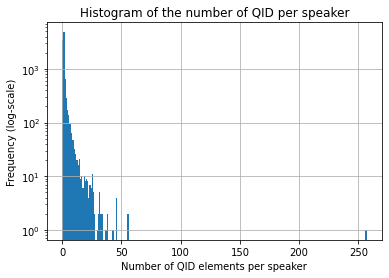

In [ ]:
# Check QID list's length of every loaded quotes 
length_qids = np.zeros(len(df_quotes))
for idx, qids in enumerate(df_quotes["qids"].values):
  length_qids[idx] = len(qids)
# Plot a histogram with log-scale on Y axis
plt.hist(length_qids, bins=int(np.max(length_qids)))
plt.yscale('log')
plt.grid('on')
plt.xlabel("Number of QID elements per speaker")
plt.ylabel("Frequency (log-scale)")
plt.title("Histogram of the number of QID per speaker")
#plt.xlim(0, 30) # Uncomment for focusing on a specific region 
plt.show()

In [ ]:
# Display the frequency using a dataframe instead of a histogram
val, freq = np.unique(length_qids, return_counts=True)
df_QID_freq = pd.DataFrame(data={"Nb. of QID":val, "Frequency":freq})
df_QID_freq.head(5)

,Nb. of QID,Frequency
0,0.0,3425
1,1.0,4832
2,2.0,663
3,3.0,285
4,4.0,170


## C) Data extraction

### 1) Generation of csvs

For simpler processing, we decide to first extract the data for each news outlet that we will analyse and store it in separate files, such that we don't need to parse the entire huge dataset every time. For each news outlet, we create one csv file containing the data for that news outlet per year, so six csv files per news outlet in total.

*Note: we choose to work with csvs instead of jsons because they are much easier to generate during the extraction of the data, since we process the data in chunks. Csvs allow to simply append the data at the end of the document, while appending to json files is much more complicated.*

During the generation of these files, we also already generate some of the data that will be useful to us during the analysis part. Each data entry will therefore have the following entries: `quoteID`, `quotation`, `speaker`, `qids`, `date`, `numOccurences`, `probas`, `quote_length`, `negative_sent`, `neutral_sent`, `positive_sent`, `compound`.

First, we create functions that we will use to process the data from quotebank and generate additional data.

In [ ]:
PUNCTUATION = set(string.punctuation)
SIA = SentimentIntensityAnalyzer()

def remove_punctuation(l):
    return [w for w in l if w not in PUNCTUATION]

def sentiment_analysis(q):
    scores = SIA.polarity_scores(q)
    return scores["neg"], scores["neu"], scores["pos"], scores["compound"]

def perform_analyses(q):
    # Compute length of quotes
    tokens = word_tokenize(q)
    quote_length = len(remove_punctuation(tokens))

    # Determine sentiment
    scores = sentiment_analysis(q)
    negative_sent, neutral_sent, positive_sent, compound = sentiment_analysis(q)

    return quote_length, negative_sent, neutral_sent, positive_sent, compound

def get_target_doms(urls, domains):
    domains_set = {get_fld(url) for url in urls}
    return domains.intersection(domains_set)

Next, we generate the csvs for each selected news outlet for each year. 

We want to minimize the runtime, so we make sure to parse the whole dataset only once and directly extract, process and write the data we want. We identify the quotes cited by our target news outlets, generate the additional data we want for them and write the data of each quote to the files of each outlet that quoted it. Additionally, since we run the code on colab, there is the risk that the code might stop running after a given duration of inactivity. Therefore, we keep track of the processing advancement using a log file that is able to recover the state of the code before it stopped running. The log file will never cause us to miss out on any data, but it might still allow for some quotes to be written twice to the same file. Therefore, we will have to drop duplicates when loading the csv files during later analyses (as is anyway the best practice when we do not use our data for machine learning, which we do not in our project).

In [ ]:
def generate_csvs(domains, year, chunksize=10000, iter_max=None, use_log=False):
    '''
    Generates a csv per news outlet for given year
    '''

    path_to_file = drive + 'Quotebank/quotes-'+ str(year) + '.json.bz2'
    df_chunks = pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=chunksize, encoding="utf-8")

    path_new_csvs = drive + 'News_outlet_csvs/' + str(year) + "/"

    if not os.path.exists(path_new_csvs):  # Create new folders if they don't already exist
        os.makedirs(path_new_csvs)

    iterations_counter = 0
    if use_log:
        log_file = path_new_csvs + str(year) + "log.txt"
        if os.path.isfile(log_file):  # If log file exists
            with open(log_file, "r") as f:
                lines = f.readlines()
                iterations_counter_log = int(lines[-1])  # Read last log entry
                f.close()
        else:
            iterations_counter_log = 0

    header = "quoteID,quotation,speaker,qids,date,numOccurences,probas,quote_length,negative_sent,neutral_sent,positive_sent,compound\n"
    for dom in domains:
        csv_file = path_new_csvs + str(year) + "_" + dom +".csv"
        if use_log:
            if not os.path.isfile(csv_file) or iterations_counter_log == 0:
                with open(csv_file, "w") as f:  # create new files with just the header if they don't yet exist or if we restart the process
                    f.write(header)
        else:
            if os.path.isfile(csv_file):  # If we don't use the log file to recover previous state, delete any existing csv_file and replace them with files containing just a header to avoid corrupted states
                os.remove(csv_file)
            with open(csv_file, "w") as f:
                f.write(header)

    for chunk in df_chunks:

        if use_log:
            if iterations_counter < iterations_counter_log:  # skip chunks until we have reached the last logged state
                if iterations_counter % 10 == 0:
                    print("Skipped chunk", iterations_counter)
                iterations_counter += 1
                continue

        if iter_max is not None and iterations_counter == iter_max:
            break

        if iterations_counter % 10 == 0:
            print("Processing chunk", iterations_counter, "of year", year)
        
        chunk["target_doms"] = chunk.urls.apply(lambda x: get_target_doms(x, domains))  # Find quotes coming from our target domains
        chunk = chunk[chunk.target_doms != set()]  # Drop entries where the quote doesn't appear in any of our target domains
        chunk.drop(["urls", "phase"], axis=1, inplace=True)  # drop columns we don't need
        chunk["quote_length"], chunk["negative_sent"], chunk["neutral_sent"], chunk["positive_sent"], chunk["compound"] = zip(*chunk.quotation.map(perform_analyses))
        
        for dom in domains:
            is_in_target_doms = chunk.target_doms.apply(lambda x: dom in x)
            data = chunk.where(is_in_target_doms)
            data.dropna(inplace=True)
            data.drop(["target_doms"], axis=1, inplace=True)
            
            csv_file = path_new_csvs + str(year) + "_" + dom +".csv"
            data.to_csv(csv_file, mode='a', header=False, index=False)
        
        iterations_counter += 1

        # Write to log file to recover previous state in case colab stops running
        if use_log:
            with open(log_file, "a") as f:
                f.write(str(iterations_counter) + "\n")
                f.close()



We retrive the domains we selected for our analysis form the csv file generated during data exploration.

In [ ]:
selected_domains_file = drive + "selected_domains.csv"
all_selected_doms = pd.read_csv(selected_domains_file)

And we generate the csvs for each news outlet for each year.

In [ ]:
years = range(2015, 2021)
chunksize = 10000
#for year in years:
#    generate_csvs(set(all_selected_doms.domain), year, chunksize=chunksize, use_log=True)  # commented such that we don't run it again when we run the entire notebook

In [ ]:
def load_csv_to_df(year, domain, folder="News_outlet_csvs"):
    path = os.path.join(drive, folder, str(year), str(year) + "_" + domain + ".csv")
    outlet_df = pd.read_csv(path, encoding="utf-8")
    return outlet_df

### 2) Gathering the most cited speakers
Method: 
  - Define a function for loading the CSV
  - We will start by filtering the outlets that are based in the US, have a political leaning and are content creator. 
  - Then we will count the occurence of each speaker based on the *QID* per outlet per year. 
  - From this we will gather a top 15 of political of democrats and republicans speakers across all years and outlets (Section D).

To prepare the data for our analysis, we first need to load it into dataframes and convert columns to the right types.

In [ ]:
# Load the domains' name
selected_domains_file = drive + "selected_domains.csv"
all_selected_doms = pd.read_csv(selected_domains_file)
# The mask for selecting the correct outlets
mask = (all_selected_doms["Nationality"]=='US') & (all_selected_doms["Content_creator"]>0) & (all_selected_doms["Political_leaning"].notnull())
political_US_outlets = all_selected_doms[mask]
political_US_outlets

,domain,Year_by_year,Cumulative,Nationality,Political_leaning,Content_creator,Traffic,Factual_reporting
2,latimes.com,0,1,US,-1.0,1,High,5.0
3,breitbart.com,1,1,US,3.0,1,High,3.0
7,wtop.com,1,0,US,0.0,1,NaN,5.0
13,chicagotribune.com,0,1,US,1.0,1,High,5.0
14,sfgate.com,1,1,US,-1.0,1,High,5.0
16,upi.com,1,1,US,0.0,1,Medium,5.0
17,chron.com,1,0,US,-1.0,1,NaN,5.0
19,cnn.com,1,1,US,-2.0,1,High,3.0
27,nytimes.com,0,1,US,-1.0,1,High,5.0
28,thehill.com,1,0,US,0.0,1,High,4.0


In [ ]:
# Define the years 
list_years = [2015, 2016, 2017, 2018, 2019, 2020]
# Define the domain names
list_domains = political_US_outlets["domain"].values

In [ ]:
# Dictionnary that stores in each year a series with the count for each speaker
dict_cumulative_counts_1 = {}
for year in list_years:
  # To store the values per year
  cumulative_count = pd.Series([], dtype=float)
  for domain in list_domains:
    df_outlet = load_csv_to_df(year, domain)
    # Use value_count form pandas to count each set of QIDS occurence and use pd.DataFrame.add
    cumulative_count = cumulative_count.add(df_outlet["qids"].value_counts(), fill_value=0)
  dict_cumulative_counts_1[year]=cumulative_count
  print("Done for year: " + str(year))

Done for year: 2015
Done for year: 2016
Done for year: 2017
Done for year: 2018
Done for year: 2019
Done for year: 2020


In [ ]:
# Export the results to CSV files
for year in list_years:
  df_year = dict_cumulative_counts_1[year]
  path = drive+"/Domains_count/"+str(year)+'_dict_counts_speakers.txt'
  df_year.to_csv(path, header=False, index=True) 

## D) Data preparation

### 1) Retrieve the most cited Democrat and Republican speakers

In [ ]:
# Load the domains' name
selected_domains_file = drive + "selected_domains.csv"
all_selected_doms = pd.read_csv(selected_domains_file)
# The mask for selecting the correct outlets
mask = (all_selected_doms["Nationality"]=='US') & (all_selected_doms["Content_creator"]>0) & (all_selected_doms["Political_leaning"].notnull())
political_US_outlets = all_selected_doms[mask]

# Define the years 
list_years = [2015, 2016, 2017, 2018, 2019, 2020]
# Define the domain names
list_domains = political_US_outlets["domain"].values

# Load cumulative speakers counts per year 
dict_cumulative_counts = {}
for year in list_years:
  path = drive+"/Domains_count/"+str(year)+'_dict_counts_speakers.txt'
  dict_cumulative_counts[year] = pd.read_csv(path, header = None, index_col = 0, squeeze = True)

#### **TBD** Most cited speakers per year

Modify the variable `year` and `max_speakers`to display the most cited speakers per year.

In [ ]:
year = 2015
max_speakers = 20
# Gather the top 20 and reset the index as column 
top_per_year = dict_cumulative_counts[year].sort_values(ascending=False).head(max_speakers).reset_index()
# Remove the first element because it is the unrecognised speakers
top_per_year.drop(index=top_per_year.index[0], axis=0, inplace=True)
# Rename column 
top_per_year.columns = ['QIDS', 'count']
# Reconvert the list (that are strings) to actual list using ast library
top_per_year["QIDS"] = top_per_year["QIDS"].apply(lambda x: (literal_eval(x)))

# Create the name column
# Retrieve the name using the wikidata function described above 
top_per_year["name"] = top_per_year.apply(lambda x: retrieve_wikidata_properties(x.QIDS[0]).iloc[0].label, axis=1)
# Same idea but for the political party, we use the first QID to retrieve the party, not a correct heuristic though 
top_per_year["party"] = top_per_year.apply(lambda x: human_readable_properties(retrieve_wikidata_properties(x.QIDS[0]), 'party'), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: There is no value for this property!


,QIDS,count,name,party
1,[Q76],24645.0,Barack Obama,[Democratic Party]
2,"[Q22686, Q27947481]",21165.0,Donald Trump,"[Republican Party, Independence Party of Ameri..."
3,[Q6294],13037.0,Hillary Clinton,"[Democratic Party, Republican Party]"
4,[Q221997],9113.0,Jeb Bush,[Republican Party]
5,[Q450675],7066.0,Francis,None
6,[Q2036942],6771.0,Ted Cruz,[Republican Party]
7,[Q324546],6294.0,Marco Rubio,[Republican Party]
8,[Q816459],5376.0,Ben Carson,"[Republican Party, Democratic Party, independe..."
9,[Q359442],5167.0,Bernie Sanders,"[Liberty Union Party, Democratic Party, indepe..."
10,[Q463557],5122.0,Rand Paul,[Republican Party]


#### Results across all years per **sets** of QIDS 

In [ ]:
# Compute this 
cumulative_count_all = pd.Series([], dtype=float)
for year in list_years:
  year_series = dict_cumulative_counts[year]
  cumulative_count_all = cumulative_count_all.add(year_series, fill_value=0)
cumulative_count_all.index.name = 'idx'

In [ ]:
max_speakers = 75
# Gather the top 20 and reset the index as column 
top_speakers = cumulative_count_all.sort_values(ascending=False).head(max_speakers).reset_index()
# Remove the first element because it is the unrecognised speakers
top_speakers.drop(index=top_speakers.index[0], axis=0, inplace=True)
# Rename column 
top_speakers.columns = ['QIDS', 'count']
# Reconvert the list (that are strings) to actual list using ast library
top_speakers["QIDS"] = top_speakers["QIDS"].apply(lambda x: (literal_eval(x)))

In [ ]:
# Create the name column
# Retrieve the name using the wikidata function described above 
top_speakers["name"] = top_speakers.apply(lambda x: retrieve_wikidata_properties(x.QIDS[0]).iloc[0].label, axis=1)
# Same idea but for the political party, we use the first QID to retrieve the party, not a correct heuristic though 
top_speakers["party"] = top_speakers.apply(lambda x: human_readable_properties(retrieve_wikidata_properties(x.QIDS[0]), 'party'), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: There is no value for this property!


For our analysis we only want to look at the speakers belonging to the Republican or Democratic party. Therefore, we drop all the speakers that are not part of one of them.

In [ ]:
top_speakers.dropna(subset=["party"], inplace = True)

In order to separate Republicans and Democrats we one-hot encode the belonging to both parties in two new columns.

In [ ]:
top_speakers["Democrat"] = top_speakers["party"].apply(lambda x: "Democratic Party" in x)
top_speakers["Republican"] = top_speakers["party"].apply(lambda x: "Republican Party" in x)

We check if some speakers belong to both parties.

In [ ]:
top_speakers[top_speakers["Democrat"] == top_speakers["Republican"]]

,QIDS,count,name,party,Democrat,Republican
1,[Q22686],285454.0,Donald Trump,"[Republican Party, Independence Party of Ameri...",True,True
2,"[Q22686, Q27947481]",89949.0,Donald Trump,"[Republican Party, Independence Party of Ameri...",True,True
4,[Q6294],38951.0,Hillary Clinton,"[Democratic Party, Republican Party]",True,True
17,[Q7747],15565.0,Vladimir Putin,"[Communist Party of the Soviet Union, Our Home...",False,False
21,[Q43723],14061.0,Benjamin Netanyahu,[Likud],False,False
27,[Q3052772],11909.0,Emmanuel Macron,"[La République En Marche, Socialist Party, ind...",False,False
30,[Q567],10871.0,Angela Merkel,"[Christian Democratic Union, Democratic Awaken...",False,False
38,[Q39259],9740.0,Recep Tayyip Erdoğan,"[National Salvation Party, Welfare Party, Virt...",False,False
53,[Q816459],7916.0,Ben Carson,"[Republican Party, Democratic Party, independe...",True,True
54,[Q264766],7662.0,Theresa May,[Conservative Party],False,False


We know for sure that Donald Trump actually belonged to the Republican Party during the time of the analysis whereas Hillary Clinton and Ben Carson do belong to the Democrat party. Thus, we manually correct their affiliation.

In [ ]:
top_speakers.at[1,"Democrat"] = False #Speakers 1 and 2 are the 2 both corresponds to Donald Trump (2 sets of QID)
top_speakers.at[2,"Democrat"] = False
top_speakers.at[4,"Republican"] = False #Speaker 4 corresponds to Hillary Clinton
top_speakers.at[53,"Republican"] = False # Speaker 53 correponds to Ben Carson

Now the only speakers that still have the same values in columns `Democrat` and `Republican`are the one that do not belong to any party so discard them.

In [ ]:
top_speakers.drop(top_speakers[top_speakers["Democrat"] == top_speakers["Republican"]].index,inplace=True)

In [ ]:
top_speakers[top_speakers["Democrat"] == top_speakers["Republican"]]

,QIDS,count,name,party,Democrat,Republican


Now we can create the two list containing the top 15 speakers of both parties that we will use for the rest of our analysis.

In [ ]:
rep_speakers = top_speakers[top_speakers["Republican"]==True].iloc[0:15]
dem_speakers = top_speakers[top_speakers["Democrat"]==True].iloc[0:15]

We will need the QIDs of all these speakers to retrieve the data of interest so we already store them in a simple list.

In [ ]:
# Get the list of the democrat speakers QID as string
dem_speakers_QIDS = []
for list_QIDS in dem_speakers.QIDS: 
  dem_speakers_QIDS.append((str(list_QIDS))) 

# Get the list of the republican speakers QID as string
rep_speakers_QIDS = []
for list_QIDS in rep_speakers.QIDS: 
  rep_speakers_QIDS.append((str(list_QIDS))) 

## E) Data Analysis

###1) Evolution in function of the year (Théo's version)

First, we wish to study the evolution of the quoting style of influential US news outlets. To that end, we plot our two parameters of interest: length (`length_mean`, number of words) and polarity score (`compound_mean`) between 2015 and 2020. The analysis is first performed for all news outlets, before separating them according to their political orientation (left-leaning, right-leaning and neutral).

**CA JE SAIS PAS SI JE SEPARE EN 2 CELL PARCE QUE LA PREMIERE C'EST LA DESCRIPTION DU QUOI, LA DEUXIEME DU COMMENT**

For these plots we only keep US news outlets that were in the top 200 news outlets with the most quotes each year, and produce their own content. In order to avoid any bias/error coming from a simple mean of mean (Simpson's paradox), we keep the number of quotes per outlet per year to compute a weighted mean and standard error of the mean (SEM).
All plots display the mean, with SEM as errorbars. The error bars are too small to be visible, which means that observable differences are significant. 
All website political orientation were taken from the website Media Bias/Fact Check (https://mediabiasfactcheck.com/). 


In [ ]:
time_scale = [2015,2016,2017,2018,2019,2020]
length_mean = []
length_error = []
length_var = []
compound_mean = [] #Mean of the polarity score
compound_error = []

for year in time_scale :
  # Temporary variables to stock intermediates means and weights
  length_mean_list = []
  compound_mean_list = []
  quotes_weight_list = []

  for row in all_selected_doms.iterrows() :
    # Select domains in top 200 every year, that are content creator and from the US
    if (row[1]["Year_by_year"] == 1) and (row[1]["Content_creator"] == 1) and (row[1]["Nationality"] == "US"):
      df_year_outlet = load_csv_to_df(year,row[1]["domain"])
      quotes_weight_list.append(df_year_outlet.shape[0]) # Save the number of quotes in each outlet
      length_mean_list.append(df_year_outlet["quote_length"].mean()) # Compute the mean length of each outlet
      compound_mean_list.append(df_year_outlet["compound"].mean()) # Compute the mean polarity score of each outlet

  # Computation of weighted mean and standard error of the mean for the length
  weighted_stats_length = DescrStatsW(length_mean_list, weights=quotes_weight_list, ddof=0)
  length_mean.append(weighted_stats_length.mean)
  length_error.append(weighted_stats_length.std_mean)
  length_var.append(weighted_stats_length.std)

  # Computation of weighted mean and standard error of the mean for the polarity score
  weighted_stats_compound = DescrStatsW(compound_mean_list, weights=quotes_weight_list, ddof=0) # We use this class from statsmodel.stats for the computation
  compound_mean.append(weighted_stats_compound.mean)
  compound_error.append(weighted_stats_compound.std_mean)

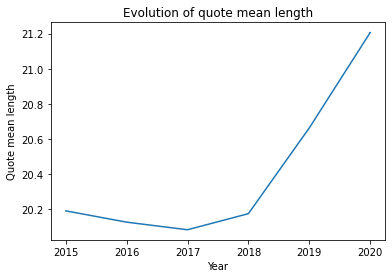

In [ ]:
plt.errorbar(time_scale,length_mean,yerr=length_error)
plt.xlabel("Year")
plt.ylabel("Quote mean length")
plt.title("Evolution of quote mean length")
plt.xticks(time_scale)
plt.show()

We can see that the mean length of quotes has remained fairly constant between 2015 and 2018, and increased between 2018 and 2020 by 1 word.

Therefore we can conclude that the average length of quotes has increased significantly between 2018 and 2020, although this difference is quite small (1 word).

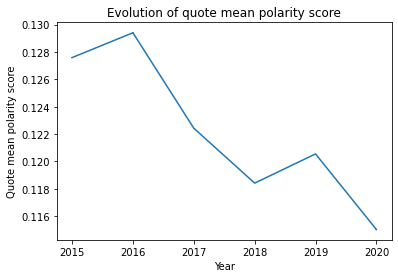

In [ ]:
plt.errorbar(time_scale,compound_mean,yerr=compound_error,)
plt.xlabel("Year")
plt.ylabel("Quote mean polarity score")
plt.title("Evolution of quote mean polarity score")
plt.xticks(time_scale)
plt.show()

Overall the quotes are slightly positive (polarity score > 0), but there is a negative trend. 

This shows the news outlets selected have on average more positive quotes, although the polarity score has been following a negative linear trend between 2015 and 2020.

In [ ]:
all_selected_doms.dropna(subset=["Political_leaning"]).head()

,domain,Year_by_year,Cumulative,Nationality,Political_leaning,Content_creator,Traffic,Factual_reporting
0,nzherald.co.nz,1,1,NZ,0.0,1,NaN,5.0
2,latimes.com,0,1,US,-1.0,1,High,5.0
3,breitbart.com,1,1,US,3.0,1,High,3.0
5,inquisitr.com,1,0,UK,-1.0,0,NaN,3.0
6,brisbanetimes.com.au,1,1,AU,-1.0,1,NaN,NaN


Next, we plot the same graph as before but we divide the news outlets in three groups based on their political orientation : Left-leaning, Right-leaning and Neutral. No difference is made within a group (no degrees of left or right).

In [ ]:
time_scale = [2015,2016,2017,2018,2019,2020]
length_mean_left, length_mean_right, length_mean_neutral = [],[],[]
length_error_left, length_error_right, length_error_neutral = [],[],[]
compound_mean_left, compound_mean_right, compound_mean_neutral = [],[],[]
compound_error_left, compound_error_right, compound_error_neutral = [],[],[]

for year in time_scale :
  # Temporary variables to stock intermediates means and weights
  quotes_weight_list_left, quotes_weight_list_right, quotes_weight_list_neutral = [],[],[]
  length_mean_list_left, length_mean_list_right, length_mean_list_neutral = [],[],[]
  compound_mean_list_left, compound_mean_list_right, compound_mean_list_neutral = [],[],[]

  for row in all_selected_doms.dropna(subset=["Political_leaning"]).iterrows() :
    if (row[1]["Year_by_year"] == 1) & (row[1]["Content_creator"] == 1) & (row[1]["Nationality"] == "US") :
      df_year_outlet = load_csv_to_df(year,row[1]["domain"])
      
      #The political_leaning variable has values between -3 (extreme left) and +3 (extreme right), 0 being neutral
      if row[1]["Political_leaning"] < 0 :
        quotes_weight_list_left.append(df_year_outlet.shape[0])
        length_mean_list_left.append(df_year_outlet["quote_length"].mean())
        compound_mean_list_left.append(df_year_outlet["compound"].mean())
        

      elif row[1]["Political_leaning"] > 0 :
        quotes_weight_list_right.append(df_year_outlet.shape[0])
        length_mean_list_right.append(df_year_outlet["quote_length"].mean())
        compound_mean_list_right.append(df_year_outlet["compound"].mean())
        

      elif row[1]["Political_leaning"] == 0 :
        quotes_weight_list_neutral.append(df_year_outlet.shape[0])
        length_mean_list_neutral.append(df_year_outlet["quote_length"].mean())
        compound_mean_list_neutral.append(df_year_outlet["compound"].mean())
        
  # Computation of weighted mean and standard error of the mean for the length
  weighted_stats_length_left = DescrStatsW(length_mean_list_left, weights=quotes_weight_list_left, ddof=0)
  length_mean_left.append(weighted_stats_length_left.mean)
  length_error_left.append(weighted_stats_length_left.std_mean)
  
  weighted_stats_length_right = DescrStatsW(length_mean_list_right, weights=quotes_weight_list_right, ddof=0)
  length_mean_right.append(weighted_stats_length_right.mean)
  length_error_right.append(weighted_stats_length_right.std_mean)

  weighted_stats_length_neutral = DescrStatsW(length_mean_list_neutral, weights=quotes_weight_list_neutral, ddof=0)
  length_mean_neutral.append(weighted_stats_length_neutral.mean)
  length_error_neutral.append(weighted_stats_length_neutral.std_mean)

  # Computation of weighted mean and standard error of the mean for the polarity score
  weighted_stats_compound_left = DescrStatsW(compound_mean_list_left, weights=quotes_weight_list_left, ddof=0)
  compound_mean_left.append(weighted_stats_compound_left.mean)
  compound_error_left.append(weighted_stats_compound_left.std_mean)
  
  weighted_stats_compound_right = DescrStatsW(compound_mean_list_right, weights=quotes_weight_list_right, ddof=0)
  compound_mean_right.append(weighted_stats_compound_right.mean)
  compound_error_right.append(weighted_stats_compound_right.std_mean)

  weighted_stats_compound_neutral = DescrStatsW(compound_mean_list_neutral, weights=quotes_weight_list_neutral, ddof=0)
  compound_mean_neutral.append(weighted_stats_compound_neutral.mean)
  compound_error_neutral.append(weighted_stats_compound_neutral.std_mean)


In [ ]:
#Compute the difference in the quote mean length of left and right-leaning news sources
length_mean_difference= list()
for item_length_right, item_length_left in zip(length_mean_right, length_mean_left):
  length_mean_difference.append(item_length_right - item_length_left)
df_length_dif= pd.DataFrame(length_mean_difference)
df_length_dif.columns = ['Length Difference']
mean_length_dif =  df_length_dif[1:].agg(['mean', 'std'])
print(mean_length_dif)

      Length Difference
mean           1.340521
std            0.117789


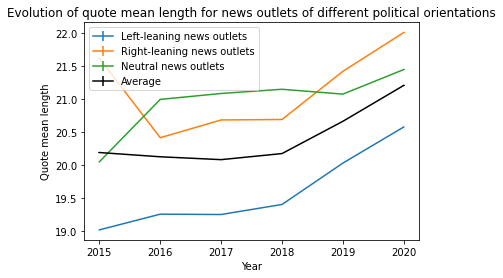

In [ ]:
plt.errorbar(time_scale,length_mean_left,yerr=length_error_left,label="Left-leaning news outlets")
plt.errorbar(time_scale,length_mean_right,yerr=length_error_right,label="Right-leaning news outlets")
plt.errorbar(time_scale,length_mean_neutral,yerr=length_error_neutral,label="Neutral news outlets")
plt.errorbar(time_scale,length_mean,yerr=length_error,label = "Average",color = "k")

plt.xlabel("Year")
plt.ylabel("Quote mean length")
plt.title("Evolution of quote mean length for news outlets of different political orientations")
plt.xticks(time_scale)
plt.legend()
plt.show()

Right-leaning news outlets have a higher mean quote length than left-leaning ones for all years. Between 2016 and 2020, the difference of left and right-leaning news outlets' mean quote length stays constant at about 1 word (mean difference=1.34, standard deviation=0.12).

Furthermore, they both follow the same evolution as the average mean quote length. This suggests the increase of quote length in news outlets is a general pattern which is independant political orientation.

**NOT SURE IF I SHOULD MENTION THIS PART:**

Additionally the neutral websites have a higher than average mean quote length. We can hypothesize that the sharp decrease of quote length between 2015 and 2016 in right-leaning media may be related to the election.



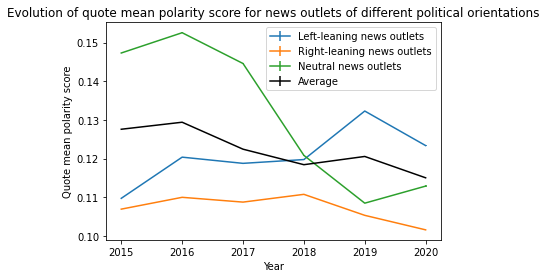

In [ ]:
plt.errorbar(time_scale,compound_mean_left,yerr=compound_error_left,label="Left-leaning news outlets")
plt.errorbar(time_scale,compound_mean_right,yerr=compound_error_right,label="Right-leaning news outlets")
plt.errorbar(time_scale,compound_mean_neutral,yerr=compound_error_neutral,label="Neutral news outlets")
plt.errorbar(time_scale,compound_mean,yerr=compound_error,label = "Average", color="k")

plt.xlabel("Year")
plt.ylabel("Quote mean polarity score")
plt.title("Evolution of quote mean polarity score for news outlets of different political orientations")
plt.xticks(time_scale)
plt.legend()
plt.show()

Left-leaning news outlets's quotes are more positive than right-leaning news outlets for all years. Left-leaning news outlets's positivity increased between 2015 and 2020, while right-leaning news outlets stayed more or less constant. Neutral news outlets changed the most, their quote mean polarity score decreased.

**Conclusion part 1**

This yearly analysis of quoting style has yielded several inputs. 
Between 2015 and 2020, quotes have on average been getting longer (20.2 to 21.2 words), are generally positive but are getting less positive (0.128 to 0.116 polarity score).

Looking at differences in the quoting styles of left and right-leaning news sources, left-leaning news outlets have on average shorter and more positive quotes than right-leaning outlets.

###1) Evolution in function of the year (Bad version)

We start by plotting the evolution of the global mean of both parameters (length and polarity score) in function of the time. For this plot we only keep US outlets that were in the top 200 each year and produce their own content. In order to avoid any bias/error coming from a simple mean of mean (Simpson's paradox), we keep the number of quotes in each outlet for each year to compute a weighted mean and standard error of the mean (SEM). 

In [ ]:
time_scale = [2015,2016,2017,2018,2019,2020]
length_mean = []
length_error = []
length_var = []
compound_mean = [] #Mean of the polarity score
compound_error = []

for year in time_scale :
  # Temporary variables to stock intermediates means and weights
  length_mean_list = []
  compound_mean_list = []
  quotes_weight_list = []

  for row in all_selected_doms.iterrows() :
    if (row[1]["Year_by_year"] == 1) and (row[1]["Content_creator"] == 1) and (row[1]["Nationality"] == "US"):
      df_year_outlet = load_csv_to_df(year,row[1]["domain"])
      quotes_weight_list.append(df_year_outlet.shape[0]) # Save the number of quotes in each outlet
      length_mean_list.append(df_year_outlet["quote_length"].mean()) # Compute the mean length of each outlet
      compound_mean_list.append(df_year_outlet["compound"].mean()) # Compute the mean polarity score of each outlet

  # Computation of weighted mean and standard error of the mean for the length
  weighted_stats_length = DescrStatsW(length_mean_list, weights=quotes_weight_list, ddof=0)
  length_mean.append(weighted_stats_length.mean)
  length_error.append(weighted_stats_length.std_mean)
  length_var.append(weighted_stats_length.std)

  # Computation of weighted mean and standard error of the mean for the polarity score
  weighted_stats_compound = DescrStatsW(compound_mean_list, weights=quotes_weight_list, ddof=0) # We use this class from statsmodel.stats for the computation
  compound_mean.append(weighted_stats_compound.mean)
  compound_error.append(weighted_stats_compound.std_mean)

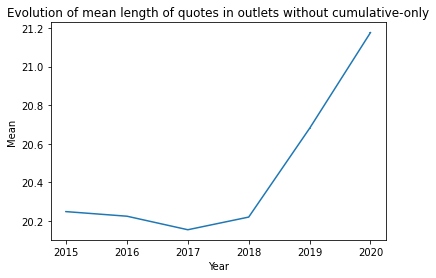

In [ ]:
plt.errorbar(time_scale,length_mean,yerr=length_error)
plt.xlabel("Year")
plt.ylabel("Mean")
plt.title("Evolution of mean length of quotes in outlets without cumulative-only")
plt.xticks(time_scale)
#plt.ylim((21.4,21.5))
plt.show()

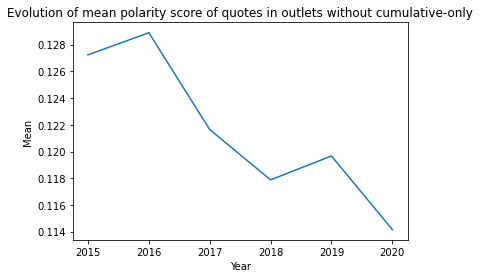

In [ ]:
plt.errorbar(time_scale,compound_mean,yerr=compound_error)
plt.xlabel("Year")
plt.ylabel("Mean")
plt.title("Evolution of mean polarity score of quotes in outlets without cumulative-only")
plt.xticks(time_scale)
#plt.ylim((21.4,21.5))
plt.show()

In [ ]:
all_selected_doms.dropna(subset=["Political_leaning"]).head()

,domain,Year_by_year,Cumulative,Nationality,Political_leaning,Content_creator,Traffic,Factual_reporting
0,nzherald.co.nz,1,1,NZ,0.0,1,NaN,5.0
2,latimes.com,0,1,US,-1.0,1,High,5.0
3,breitbart.com,1,1,US,3.0,1,High,3.0
5,inquisitr.com,1,0,UK,-1.0,0,NaN,3.0
6,brisbanetimes.com.au,1,1,AU,-1.0,1,NaN,NaN


Next, we plot the same graph as before but we divide the outlets in three groups based on their political bias : Left-biased, Right-biased and Neutral/Least-biased.

In [ ]:
time_scale = [2015,2016,2017,2018,2019,2020]
length_mean_left, length_mean_right, length_mean_neutral = [],[],[]
length_error_left, length_error_right, length_error_neutral = [],[],[]
compound_mean_left, compound_mean_right, compound_mean_neutral = [],[],[]
compound_error_left, compound_error_right, compound_error_neutral = [],[],[]

for year in time_scale :
  # Temporary variables to stock intermediates means and weights
  quotes_weight_list_left, quotes_weight_list_right, quotes_weight_list_neutral = [],[],[]
  length_mean_list_left, length_mean_list_right, length_mean_list_neutral = [],[],[]
  compound_mean_list_left, compound_mean_list_right, compound_mean_list_neutral = [],[],[]

  for row in all_selected_doms.dropna(subset=["Political_leaning"]).iterrows() :
    if (row[1]["Year_by_year"] == 1) & (row[1]["Content_creator"] == 1) & (row[1]["Nationality"] == "US") :
      df_year_outlet = load_csv_to_df(year,row[1]["domain"])
      
      if row[1]["Political_leaning"] < 0 :
        quotes_weight_list_left.append(df_year_outlet.shape[0])
        length_mean_list_left.append(df_year_outlet["quote_length"].mean())
        compound_mean_list_left.append(df_year_outlet["compound"].mean())
        

      elif row[1]["Political_leaning"] > 0 :
        quotes_weight_list_right.append(df_year_outlet.shape[0])
        length_mean_list_right.append(df_year_outlet["quote_length"].mean())
        compound_mean_list_right.append(df_year_outlet["compound"].mean())
        

      elif row[1]["Political_leaning"] == 0 :
        quotes_weight_list_neutral.append(df_year_outlet.shape[0])
        length_mean_list_neutral.append(df_year_outlet["quote_length"].mean())
        compound_mean_list_neutral.append(df_year_outlet["compound"].mean())
        
  # Computation of weighted mean and standard error of the mean for the length
  weighted_stats_length_left = DescrStatsW(length_mean_list_left, weights=quotes_weight_list_left, ddof=0)
  length_mean_left.append(weighted_stats_length_left.mean)
  length_error_left.append(weighted_stats_length_left.std_mean)
  
  weighted_stats_length_right = DescrStatsW(length_mean_list_right, weights=quotes_weight_list_right, ddof=0)
  length_mean_right.append(weighted_stats_length_right.mean)
  length_error_right.append(weighted_stats_length_right.std_mean)

  weighted_stats_length_neutral = DescrStatsW(length_mean_list_neutral, weights=quotes_weight_list_neutral, ddof=0)
  length_mean_neutral.append(weighted_stats_length_neutral.mean)
  length_error_neutral.append(weighted_stats_length_neutral.std_mean)

  # Computation of weighted mean and standard error of the mean for the polarity score
  weighted_stats_compound_left = DescrStatsW(compound_mean_list_left, weights=quotes_weight_list_left, ddof=0)
  compound_mean_left.append(weighted_stats_compound_left.mean)
  compound_error_left.append(weighted_stats_compound_left.std_mean)
  
  weighted_stats_compound_right = DescrStatsW(compound_mean_list_right, weights=quotes_weight_list_right, ddof=0)
  compound_mean_right.append(weighted_stats_compound_right.mean)
  compound_error_right.append(weighted_stats_compound_right.std_mean)

  weighted_stats_compound_neutral = DescrStatsW(compound_mean_list_neutral, weights=quotes_weight_list_neutral, ddof=0)
  compound_mean_neutral.append(weighted_stats_compound_neutral.mean)
  compound_error_neutral.append(weighted_stats_compound_neutral.std_mean)


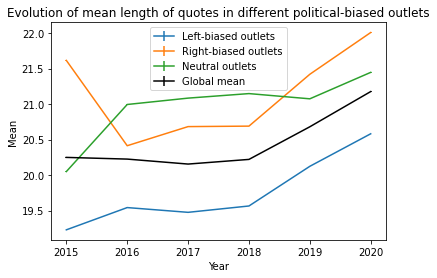

In [ ]:
plt.errorbar(time_scale,length_mean_left,yerr=length_error_left,label="Left-biased outlets")
plt.errorbar(time_scale,length_mean_right,yerr=length_error_right,label="Right-biased outlets")
plt.errorbar(time_scale,length_mean_neutral,yerr=length_error_neutral,label="Neutral outlets")
plt.errorbar(time_scale,length_mean,yerr=length_error,label = "Global mean",color = "k")

plt.xlabel("Year")
plt.ylabel("Mean")
plt.title("Evolution of mean length of quotes in different political-biased outlets")
plt.xticks(time_scale)
plt.legend()
plt.show()

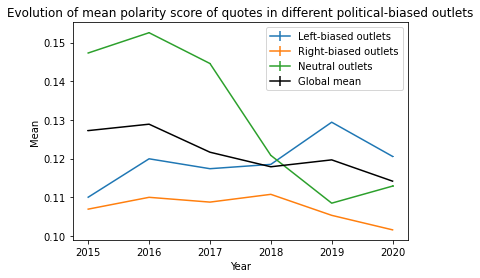

In [ ]:
plt.errorbar(time_scale,compound_mean_left,yerr=compound_error_left,label="Left-biased outlets")
plt.errorbar(time_scale,compound_mean_right,yerr=compound_error_right,label="Right-biased outlets")
plt.errorbar(time_scale,compound_mean_neutral,yerr=compound_error_neutral,label="Neutral outlets")
plt.errorbar(time_scale,compound_mean,yerr=compound_error,label = "Global mean", color="k")

plt.xlabel("Year")
plt.ylabel("Mean")
plt.title("Evolution of mean polarity score of quotes in different political-biased outlets")
plt.xticks(time_scale)
plt.legend()
plt.show()

### 2)

See below the description of the variables we will store in the columns. The rows will represent the years. 
- `L` for outlet having a left political bias
  - `N` for neutral 
  - `R` for right
- `Pol` for the average polarity score 
- `Pol_err` for average polarity error 
- `Len` for the average quote's length
- `Len_err` for average quote's length error
- `Count` for the occurence of democrats/republicans speaker in the given outlet having political leaning L/N/R 

In [ ]:
time_scale = [2015,2016,2017,2018,2019,2020]
# Define the dataframes storing the reslts 
col_name = ['L_Pol', 'L_Pol_err', 'L_Len', 'L_Len_err', 'L_Count', 'N_Pol', 'N_Pol_err', 'N_Len', 'N_Len_err', 'N_Count', 'R_Pol', 'R_Pol_err', 'R_Len', 'R_Len_err', 'R_Count']
# The democract df
df_speakers_stats_dem = pd.DataFrame(columns=col_name, index=time_scale)
# The republican df 
df_speakers_stats_rep = pd.DataFrame(columns=col_name, index=time_scale)



# (2,1) vectors : vec[0] corresponds to Democrat's value and vec[1] to Republican's value
total_length_mean_left, total_length_mean_right, total_length_mean_neutral = [],[],[]
total_length_error_left, total_length_error_right, total_length_error_neutral = [],[],[]
total_compound_mean_left, total_compound_mean_right, total_compound_mean_neutral = [],[],[]
total_compound_error_left, total_compound_error_right, total_compound_error_neutral = [],[],[]
total_count_left, total_count_right, total_count_neutral = [],[],[]

for year in time_scale :

  
  # 1) Start by retrieving the data


  # Temporary variables to stock intermediates means and weights for republican speakers
  quotes_count_list_left_rep, quotes_count_list_right_rep, quotes_count_list_neutral_rep = [],[],[]
  length_mean_list_left_rep, length_mean_list_right_rep, length_mean_list_neutral_rep = [],[],[]
  compound_mean_list_left_rep, compound_mean_list_right_rep, compound_mean_list_neutral_rep = [],[],[]
  # Temporary variables to stock intermediates means and weights for democrat speakers
  quotes_count_list_left_dem, quotes_count_list_right_dem, quotes_count_list_neutral_dem = [],[],[]
  length_mean_list_left_dem, length_mean_list_right_dem, length_mean_list_neutral_dem = [],[],[]
  compound_mean_list_left_dem, compound_mean_list_right_dem, compound_mean_list_neutral_dem = [],[],[]

  for row in political_US_outlets.iterrows() :
    df_year_outlet = load_csv_to_df(year,row[1]["domain"]).dropna(subset=["qids"])
    # Make sure that we have a not empty dataframe 
    if not df_year_outlet.empty:
      # Groupy by the QIDS, and aggregate by mean on quote_length and compound value
      qids_group_by = df_year_outlet.groupby("qids").agg({"quote_length" : "mean", "compound" : "mean"}).reset_index()
      # Count the number of quotes per QIDS
      qids_count = df_year_outlet.groupby("qids").size()
      
      # Iterate on the QIDS/speakers of the given outlet and check whether they belong to democrat or republican 
      for qid in qids_group_by["qids"].values:
        # Check if the speaker is a DEMOCRAT
        if qid in dem_speakers_QIDS : 
          # Check whether the outlet has a Left political bias 
          if row[1]["Political_leaning"] < 0:
            quotes_count_list_left_dem.append(qids_count.loc[qid])
            length_mean_list_left_dem.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_left_dem.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])
          # Check whether the outlet has a Neutral political bias 
          if row[1]["Political_leaning"] > 0:
            quotes_count_list_right_dem.append(qids_count.loc[qid])
            length_mean_list_right_dem.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_right_dem.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])
          # Check whether the outlet has a Right political bias 
          if row[1]["Political_leaning"] == 0:
            quotes_count_list_neutral_dem.append(qids_count.loc[qid])
            length_mean_list_neutral_dem.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_neutral_dem.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])
         # Check if the speaker is REPUBLICAN
        if qid in rep_speakers_QIDS :

          if row[1]["Political_leaning"] < 0:
            quotes_count_list_left_rep.append(qids_count.loc[qid])
            length_mean_list_left_rep.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_left_rep.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])

          if row[1]["Political_leaning"] > 0:
            quotes_count_list_right_rep.append(qids_count.loc[qid])
            length_mean_list_right_rep.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_right_rep.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])

          if row[1]["Political_leaning"] == 0:
            quotes_count_list_neutral_rep.append(qids_count.loc[qid])
            length_mean_list_neutral_rep.append(qids_group_by[qids_group_by["qids"] == qid]["quote_length"].values[0])
            compound_mean_list_neutral_rep.append(qids_group_by[qids_group_by["qids"] == qid]["compound"].values[0])
          
    
    
    
  # 2) After retrieving the data, compute the STATISTICS
  



  #################################################### FOR DEMOCRATS #########################################################  

  yearly_stats_dem = [] # list to push in the final dataframe

  #Left outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_left_dem = DescrStatsW(compound_mean_list_left_dem, weights=quotes_count_list_left_dem, ddof=0)
  yearly_stats_dem.append(weighted_stats_compound_left_dem.mean)
  yearly_stats_dem.append(weighted_stats_compound_left_dem.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_left_dem = DescrStatsW(length_mean_list_left_dem, weights=quotes_count_list_left_dem, ddof=0)
  yearly_stats_dem.append(weighted_stats_length_left_dem.mean)
  yearly_stats_dem.append(weighted_stats_length_left_dem.std_mean)

  #Count for left :
  yearly_stats_dem.append(np.array(quotes_count_list_left_dem).sum())

  #Neutral outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_neutral_dem = DescrStatsW(compound_mean_list_neutral_dem, weights=quotes_count_list_neutral_dem, ddof=0)
  yearly_stats_dem.append(weighted_stats_compound_neutral_dem.mean)
  yearly_stats_dem.append(weighted_stats_compound_neutral_dem.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_neutral_dem = DescrStatsW(length_mean_list_neutral_dem, weights=quotes_count_list_neutral_dem, ddof=0)
  yearly_stats_dem.append(weighted_stats_length_neutral_dem.mean)
  yearly_stats_dem.append(weighted_stats_length_neutral_dem.std_mean)

  #Count for Neutral :
  yearly_stats_dem.append(np.array(quotes_count_list_neutral_dem).sum())

  #Right outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_right_dem = DescrStatsW(compound_mean_list_right_dem, weights=quotes_count_list_right_dem, ddof=0)
  yearly_stats_dem.append(weighted_stats_compound_right_dem.mean)
  yearly_stats_dem.append(weighted_stats_compound_right_dem.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_right_dem = DescrStatsW(length_mean_list_right_dem, weights=quotes_count_list_right_dem, ddof=0)
  yearly_stats_dem.append(weighted_stats_length_right_dem.mean)
  yearly_stats_dem.append(weighted_stats_length_right_dem.std_mean)

  #Count for Right :
  yearly_stats_dem.append(np.array(quotes_count_list_right_dem).sum())

  # Push the results into the df 
  df_speakers_stats_dem.loc[year] = yearly_stats_dem 

  #################################################### FOR REPUBLICAN #########################################################  

  yearly_stats_rep = [] # list to push in the final dataframe

  #Left outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_left_rep = DescrStatsW(compound_mean_list_left_rep, weights=quotes_count_list_left_rep, ddof=0)
  yearly_stats_rep.append(weighted_stats_compound_left_rep.mean)
  yearly_stats_rep.append(weighted_stats_compound_left_rep.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_left_rep = DescrStatsW(length_mean_list_left_rep, weights=quotes_count_list_left_rep, ddof=0)
  yearly_stats_rep.append(weighted_stats_length_left_rep.mean)
  yearly_stats_rep.append(weighted_stats_length_left_rep.std_mean)

  #Count for left :
  yearly_stats_rep.append(np.array(quotes_count_list_left_rep).sum())

  #Neutral outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_neutral_rep = DescrStatsW(compound_mean_list_neutral_rep, weights=quotes_count_list_neutral_rep, ddof=0)
  yearly_stats_rep.append(weighted_stats_compound_neutral_rep.mean)
  yearly_stats_rep.append(weighted_stats_compound_neutral_rep.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_neutral_rep = DescrStatsW(length_mean_list_neutral_rep, weights=quotes_count_list_neutral_rep, ddof=0)
  yearly_stats_rep.append(weighted_stats_length_neutral_rep.mean)
  yearly_stats_rep.append(weighted_stats_length_neutral_rep.std_mean)

  #Count for neutral :
  yearly_stats_rep.append(np.array(quotes_count_list_neutral_rep).sum())

  #Right outlets :

  # Computation of mean and SEM for polarity score
  weighted_stats_compound_right_rep = DescrStatsW(compound_mean_list_right_rep, weights=quotes_count_list_right_rep, ddof=0)
  yearly_stats_rep.append(weighted_stats_compound_right_rep.mean)
  yearly_stats_rep.append(weighted_stats_compound_right_rep.std_mean)

  # Computation of mean and SEM for length
  weighted_stats_length_right_rep = DescrStatsW(length_mean_list_right_rep, weights=quotes_count_list_right_rep, ddof=0)
  yearly_stats_rep.append(weighted_stats_length_right_rep.mean)
  yearly_stats_rep.append(weighted_stats_length_right_rep.std_mean)

  #Count for right :
  yearly_stats_rep.append(np.array(quotes_count_list_right_rep).sum())

  # Push the results into the df 
  df_speakers_stats_rep.loc[year] = yearly_stats_rep

  # To keep track of the progress 
  print("Done for year: " + str(year)) 

  



Done for year: 2015
Done for year: 2016
Done for year: 2017
Done for year: 2018
Done for year: 2019
Done for year: 2020


In [ ]:
df_speakers_stats_dem.head(6)

,L_Pol,L_Pol_err,L_Len,L_Len_err,L_Count,N_Pol,N_Pol_err,N_Len,N_Len_err,N_Count,R_Pol,R_Pol_err,R_Len,R_Len_err,R_Count
2015,0.0771815,0.000265631,19.9727,0.0123081,37877,0.103781,0.000531764,20.4276,0.0214962,10461,0.0712252,0.000368541,23.1722,0.0315093,18497
2016,0.0888006,0.00028586,19.5664,0.0125095,30474,0.104512,0.000852697,21.6488,0.0382898,5905,0.0836185,0.000351611,20.9257,0.015071,17582
2017,0.0625622,0.00047482,19.6372,0.0211678,18034,0.0504796,0.00071748,21.4499,0.0286184,5853,0.0524413,0.000634487,21.2274,0.0273854,11005
2018,0.0726006,0.000552276,19.7297,0.0251648,14293,0.0618534,0.000849529,21.939,0.038809,6014,0.0634342,0.000494719,21.8996,0.0269668,11262
2019,0.0636577,0.000276032,19.662,0.0168749,32291,0.0655277,0.000485359,21.9286,0.0297682,9970,0.0580618,0.00024684,22.2775,0.0170121,27005
2020,0.0642667,0.000602276,19.5252,0.0298069,12618,0.0649828,0.00115321,21.6443,0.0572883,3697,0.0497961,0.000571691,22.2083,0.035578,10160


In [ ]:
np.array(df_speakers_stats_dem["L_Len"])

array([19.9727275127386, 19.566351644024415, 19.63724076743928,
       19.729657874484012, 19.661980118299216, 19.525202092249167],
      dtype=object)

In [ ]:
df_speakers_stats_total = pd.DataFrame(columns=col_name,index=["total"])

In [ ]:
df_speakers_stats_total.head()

,L_Pol,L_Pol_err,L_Len,L_Len_err,L_Count,N_Pol,N_Pol_err,N_Len,N_Len_err,N_Count,R_Pol,R_Pol_err,R_Len,R_Len_err,R_Count
total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for pref in ["L_","N_","R_"]:
  columns = [pref+"Pol",pref+"Pol_err",pref+"Len",pref+"Len_err",pref+"Count"]
  print(columns)

['L_Pol', 'L_Pol_err', 'L_Len', 'L_Len_err', 'L_Count']
['N_Pol', 'N_Pol_err', 'N_Len', 'N_Len_err', 'N_Count']
['R_Pol', 'R_Pol_err', 'R_Len', 'R_Len_err', 'R_Count']


In [ ]:
X = ['Democrat','Republican']

Z = [2,3,4]
_X = np.arange(len(X))

plt.bar(_X - 0.2, Y, 0.4)
plt.bar(_X + 0.2, Z, 0.4)
plt.xticks(_X, X) # set labels manually
plt.show()

## F) TBD (ça va dégager)

For now, this section only contains code that we will eventually use later.

### 1. Get each speaker's vocabulary

#### I) Tokenise the sentences (turn them into single words)

* [Some interesting information on tokenization](https://towardsdatascience.com/overview-of-nlp-tokenization-algorithms-c41a7d5ec4f9)
* [Multi-Word Expression tokenizer](https://www.nltk.org/_modules/nltk/tokenize/mwe.html)

In [ ]:
df_quotes["tokenized_quote"] = df_quotes.quotation.apply(word_tokenize)  # Tokenize quotes and add them in the dataframe as new column
df_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,tokenized_quote,sentiment
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E,"[[, D, ], espite, the, efforts, of, the, partn...","{'neg': 0.0, 'neu': 0.768, 'pos': 0.232, 'comp..."
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E,"[[, Department, of, Homeland, Security, ], was...","{'neg': 0.184, 'neu': 0.579, 'pos': 0.237, 'co..."
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E,"[..., He, (, Madhav, ), also, disclosed, that,...","{'neg': 0.113, 'neu': 0.84, 'pos': 0.046, 'com..."
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,2,"[[None, 0.581], [Andy Harris, 0.4191]]",[https://patriotpost.us/opinion/68622-trump-bu...,E,"[..., [, I, ], f, it, gets, to, the, floor, ,]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E,"[[, I, met, them, ], when, they, just, turned,...","{'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'comp..."


Issue to solve: We need to find a way to reconstruct such abbreviated words like in the cell below...

In [ ]:
word_tokenize("it's, they're, can't")

['it', "'s", ',', 'they', "'re", ',', 'ca', "n't"]

Issue to solve: Handle words or letter in squared brackets, as we can see in the next cell
* Single letter likely to belong to next word
* One or more words in these brackets were not spoken by the speaker

In [ ]:
df_quotes.loc[0][["quotation", "tokenized_quote"]]

quotation          [ D ] espite the efforts of the partners to cr...
tokenized_quote    [[, D, ], espite, the, efforts, of, the, partn...
Name: 0, dtype: object

#### II) Sentiment analysis

In [ ]:
sia = SentimentIntensityAnalyzer()
#sia.polarity_scores("Hi, how are you?")
#sia.polarity_scores("Wow, NLTK is really powerful!")
sia.polarity_scores("You are a piece of shit!!")  # Just a test for a negative sentence. Don't take it personnally

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'compound': -0.6351, 'neg': 0.511, 'neu': 0.489, 'pos': 0.0}

In [ ]:
df_quotes["sentiment"] = df_quotes.quotation.apply(sia.polarity_scores)
df_quotes.sentiment.head()

0    {'neg': 0.0, 'neu': 0.768, 'pos': 0.232, 'comp...
1    {'neg': 0.184, 'neu': 0.579, 'pos': 0.237, 'co...
2    {'neg': 0.113, 'neu': 0.84, 'pos': 0.046, 'com...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'comp...
Name: sentiment, dtype: object

#### III) Remove punctuation and stopwords, lowercase everything

In [ ]:
#should be easy enough, don't mess it up

EN_STOPWORDS = set(stopwords.words("english"))  # English stopwords
PUNCTUATION = set(string.punctuation)  # Punctuation

def lowercase(l):
    return [w.lower() for w in l]

def remove_stopwords(l):
    return [w for w in l if w.lower() not in EN_STOPWORDS]

def remove_punctuation(l):
    return [w for w in l if w not in PUNCTUATION]

def process_tokens(l):
    l = lowercase(l)  # Lowercase tokens
    l = remove_stopwords(l)   # Remove stopwords from tokens
    l = remove_punctuation(l)  # Remove punctuation from tokens
    return l

df_quotes["tokenized_quote"] = df_quotes.tokenized_quote.apply(process_tokens)
df_quotes[["quotation", "tokenized_quote"]].head()

,quotation,tokenized_quote
0,[ D ] espite the efforts of the partners to cr...,"[espite, efforts, partners, create, non-politi..."
1,[ Department of Homeland Security ] was livid ...,"[department, homeland, security, livid, strong..."
2,... He (Madhav) also disclosed that the illega...,"[..., madhav, also, disclosed, illegal, bribe,..."
3,"... [ I ] f it gets to the floor,","[..., f, gets, floor]"
4,[ I met them ] when they just turned 4 and 7. ...,"[met, turned, 4, 7, little, felt, like, full-b..."


#### IV) Lemmatize the words (i.e. {'eating', 'eat', 'ate'} -> "eat")
* [Source](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python)

In [ ]:
WNL = WordNetLemmatizer()

def lem_words(l):
    return [WNL.lemmatize(w, pos='v') for w in l]  # POS = part-of-speech, used to give context to the lemmatizer ('v' -> verb)

df_quotes["tokenized_quote"] = df_quotes.tokenized_quote.apply(lem_words)  # Lemmatize tokens
df_quotes[["quotation", "tokenized_quote"]].head()

,quotation,tokenized_quote
0,[ D ] espite the efforts of the partners to cr...,"[espite, efforts, partner, create, non-politic..."
1,[ Department of Homeland Security ] was livid ...,"[department, homeland, security, livid, strong..."
2,... He (Madhav) also disclosed that the illega...,"[..., madhav, also, disclose, illegal, bribe, ..."
3,"... [ I ] f it gets to the floor,","[..., f, get, floor]"
4,[ I met them ] when they just turned 4 and 7. ...,"[meet, turn, 4, 7, little, felt, like, full-bl..."


#### V) Pool tokens by speaker

In [ ]:
# TODO

### 2. Assign an 'importance' score to each word

#### I) Cambridge dictionary CEFR score and register

In [ ]:
def retrieve_CEFR_levels_registers(word):
  """ Functions that retrives the ECFR level of the given word as well as its register
      Input: 
        word - a string the word you want to inspect 
      Output: 
        levels - a numpy array containing strings, if empty no info was available
        registers - a list of strings, if empty no info was available
  """
  # Make a request to Cambridge dictionnary - simply add "word" to the url  
  url = 'https://dictionary.cambridge.org/dictionary/english/'+word
  # Websites don't like it when bots connect to them, so we have to pretend being a web browser! 
  req = ul.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
  client = ul.urlopen(req)
  # Read and store data into htmldata 
  htmldata = client.read()
  client.close()

  # Create a beautiful soup element and parse it as an html file
  parsed_page = soup(htmldata, "html.parser")

  # A bit of backgrond:
  # In order to display the ECFR classification, the website uses <span> tags with a unique CSS class
  # The class is called "epp-xref dxref XX", where XX is any of the levels A1 to C2
  # Now we use 'bs4.find_all' to retrieve all span tag with the given class 
  # If none are returned, it means the level is not contained in the word 

  # Tag specific to the ECFR classification CSS class  
  class_name_level = "epp-xref dxref " 

  # The ECFR classification spans from A1 to C2, test for each case
  cases = np.array(["A1", "A2", "B1", "B2", "C1", "C2"])
  # We store the results in a bool vector from A1 to C2, corresponding to the level of the word  
  results = []
  for case in cases:
    # This checks how many times the case is present on page
    occurences = len(parsed_page.find_all("span", class_= class_name_level+case))
    # If the case is present more than 0 times, then the word can be classified in the given case 
    if occurences > 0:
      results.append(True)
    else: 
      results.append(False) 

  # Now let's retrieve the registers
  # We can apply the same strategy, the register of the word is contained in CSS class "usage dusage"

  class_name_register = "usage dusage"
  parsed_registers = parsed_page.find_all("span", class_=class_name_register)
  registers = []
  for register in parsed_registers:
    # Simply extract the information between the tags "span" with class class_name_register
    registers.append(register.string)

  return cases[results], registers

In [ ]:
# Add line for the word you want to look for 
levels, reg = retrieve_CEFR_levels_registers("exhaustive")
print(levels, reg)

['C1'] []


#### II) CEFR level of sentences

Try to implement something similar to `retrieve_ECFR_levels_registers(word)` using the web site [English Profile](http://englishprofile.org/wordlists/text-inspector) for analysing a whole sentence and get the CEFR level of each word (may be better for analysing whole quotes, and does not require stemming.)

In [ ]:
# TODO Quentin, give it a try and see how far I can go 

### 3. Create a vocabulary specific to each category in interest

#### Classify speakers into categories of interest

* Each speaker can belong to multiple categories

In [ ]:
df_quotes.sample(10)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
4411,2020-02-22-033984,There is no truth in that strange and weighty ...,Timipre Sylva,[Q3509607],2020-02-22 18:00:44,1,"[[Timipre Sylva, 0.6975], [None, 0.3025]]",[https://thewhistler.ng/bayelsa-verdict-the-od...,E
6001,2020-02-08-024054,India's overall debt-to-GDP ratio is an outlie...,Piyush Garg,[Q58208547],2020-02-08 15:07:00,3,"[[Piyush Garg, 0.9364], [None, 0.0636]]",[http://wap.business-standard.com/article/econ...,E
5888,2020-03-28-013310,"If I'm going to use one word, I think Penn Sta...",None,[],2020-03-28 03:12:55,1,"[[None, 0.6998], [Kyle Larson, 0.3002]]",[https://onwardstate.com/2020/03/27/virtual-up...,E
763,2020-01-20-025673,"I think for me, it's that open book,",None,[],2020-01-20 22:23:20,3,"[[None, 0.5348], [Ron Roenicke, 0.3385], [Alex...",[https://www.bostonherald.com/2020/01/20/red-s...,E
891,2020-01-08-036592,"If you elect me to the Oval Office, I will soa...",Elizabeth Warren,[Q434706],2020-01-08 22:10:40,2,"[[Elizabeth Warren, 0.8726], [None, 0.1161], [...",[https://blog.heartland.org/2020/01/time-for-s...,E
1741,2020-01-02-052355,The leadership challenge then is how do you re...,None,[],2020-01-02 00:00:00,1,"[[None, 0.5326], [Hao Chen, 0.4674]]",[https://www.forbes.com/sites/sallypercy/2020/...,E
2216,2020-03-28-035999,"We initially screen patients as they arrive here,",Eric Hill,"[Q12714522, Q21458196, Q2901293, Q5386728, Q53...",2020-03-28 07:56:47,1,"[[Eric Hill, 0.6783], [None, 0.3217]]",[https://www.thedenverchannel.com/news/local-n...,E
2861,2020-01-10-013628,create new cyber operations centres,Penny Mordaunt,[Q580464],2020-01-10 21:27:21,1,"[[Penny Mordaunt, 0.941], [None, 0.0438], [Ben...",[http://www.independent.co.uk/news/uk/home-new...,E
1484,2020-03-03-046862,She did nothing but talk to me during Cabinet ...,Vitaliano Aguirre II,[Q24852563],2020-03-03 05:21:00,1,"[[Vitaliano Aguirre II, 0.7682], [None, 0.2318]]",[https://www.philstar.com/headlines/2020/03/03...,E
3961,2020-03-31-041019,Our country's political world must stand at th...,Kyriakos Mitsotakis,[Q552751],2020-03-31 12:47:00,1,"[[Kyriakos Mitsotakis, 0.858], [None, 0.142]]",[https://timesofmalta.com/articles/view/greek-...,E


In [ ]:
# A small scale test on quote 6685
quote_nb = 6001
print("The quote is: \n"+df_quotes.loc[quote_nb].quotation)

The quote is: 
India's overall debt-to-GDP ratio is an outlier among emerging markets,


In [ ]:
df_quotes.loc[1741].urls

['https://www.forbes.com/sites/sallypercy/2020/01/02/an-international-perspective-top-leadership-challenges-for-2020/']

In [ ]:
# Extract the word 'commited' and get the CEFR (totally empirical, we are waiting on a better tokenizer)
levels, reg = retrieve_CEFR_levels_registers(df_quotes.loc[quote_nb].quotation.split()[6])
print(levels, reg)

NameError: ignored

Now get some info about the speaker. Use the data provided in the .parquet file.

In [ ]:
# Find the QID of the speaker 
QID = df_quotes.loc[quote_nb].qids[0]
# Display the known properties for the persone given
df_properties = retrieve_wikidata_properties(QID)
df_properties

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3793841,None,[+1946-10-16T00:00:00Z],None,[Q6581097],1341628735,None,None,[Q40348],None,None,Q24852563,Vitaliano Aguirre II,None,item,None


In [ ]:
# Retrieve the occupation in human readable format 
human_readable_properties(df_properties, "occupation")

['lawyer']

In [ ]:
# Retrieve the nationality in human readable format 
human_readable_properties(df_properties, "nationality")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: There is no value for this property!


In [ ]:
# Retrieve the candidacy in human readable format 
human_readable_properties(df_properties, "candidacy")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: There is no value for this property!


##### nltk.collocations without POS tags

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

PUNCTUATION = set(string.punctuation)  # Punctuation
EN_STOPWORDS = set(stopwords.words("english"))  # English stopwords

def format_quote_for_collocation_finder(l):
    newL = [w.lower() for w in l]  # lowercase everything
    newL = ["<P>" if w in PUNCTUATION else w for w in newL]  # We don't remove punctuation yet, as they act as separators between words, which we need to construct meaningful bigrams for collocation finding. Instead, we replace them by a punctuation tag
    newL = ["<S>" if w in EN_STOPWORDS else w for w in newL]  # We don't remove the stopwords yet, as they act as separators between non-stopwords which we need to construct meaningful bigrams for collocation finding. Instead, we replace them by a stopword tag
    # We add starting and ending tags to mark end of quotes and avoid constructing bigrams of the end word of a quote and the start word of the next one which is unrelated.
    newL.insert(0, "<B>")  # Add begin tag
    newL.append("<E>")  # Add end tag
    return newL

marked_quotes = quotes_selected_speakers.tokenized_quote.apply(format_quote_for_collocation_finder)
all_marked_quotes = [token for l in marked_quotes for token in l]

In [ ]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_marked_quotes)

frequency = 4  # Minimum number of occurences of the bigram
finder.apply_freq_filter(frequency)

finder.nbest(bigram_measures.pmi, 15)  # n most collocated words
#finder.score_ngrams(bigram_measures.pmi)  # Scores

##### nltk.collocations with POS tags

In [ ]:
nltk.download('averaged_perceptron_tagger')

def format_quote_for_collocation_finder_tagged(l):
    newL = nltk.pos_tag(l)
    newL = [(w.lower(), tag) for (w, tag) in newL]  # lowercase everything
    newL = [("<P>", "TAG-P") if w in PUNCTUATION else (w, tag) for (w, tag) in newL]  # We don't remove punctuation yet, as they act as separators between words, which we need to construct meaningful bigrams for collocation finding. Instead, we replace them by a punctuation tag
    newL = [("<S>", "TAG-S") if w in EN_STOPWORDS else (w, tag) for (w, tag) in newL]  # We don't remove the stopwords yet, as they act as separators between non-stopwords which we need to construct meaningful bigrams for collocation finding. Instead, we replace them by a stopword tag
    # We add starting and ending tags to mark end of quotes and avoid constructing bigrams of the end word of a quote and the start word of the next one which is unrelated.
    newL.insert(0, ("<B>", "TAG-B"))  # Add begin tag with random POS tag
    newL.append(("<E>", "TAG-E"))  # Add end tag with random POS tag
    return newL

marked_quotes_tagged = quotes_selected_speakers.tokenized_quote.apply(format_quote_for_collocation_finder_tagged)
all_marked_quotes_tagged = [token for l in marked_quotes_tagged for token in l]

In [ ]:
finder_tagged = BigramCollocationFinder.from_words(all_marked_quotes_tagged)
frequency_tagged = 3
finder_tagged.apply_freq_filter(frequency_tagged)
finder_tagged.nbest(bigram_measures.pmi, 15)  # n most collocated words

##### Named entity recognition

In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

ner_quotes = quotes_selected_speakers.tokenized_quote.apply(nltk.pos_tag)
ner_quotes = ner_quotes.apply(nltk.ne_chunk)
ner_quotes.head()

In [ ]:
print(ner_quotes[86])

In [ ]:
# A failed attempt to unravel the list of QIDS per speaker efficiently and then count the occurence of each speaker across the years 
# One should allocate the memory before running the algorithm, otherwise too slow 


from tqdm import tqdm
# Concatenate values across years 
# To do this we need to expand the QIDS (which are lists) to single element
# Store the final values - not used yet 
final_counts = pd.DataFrame(columns=['QIDS', 'Counts'])
# Store the extended QIDS for each year 
extended_QIDS = {}
for year in list_years:
  # New variable to store the values per year, set the index as column of QIDS
  yearly_series = dict_cumulative_counts[year].reset_index()
  # Change the columns names
  yearly_series.columns = ['QIDS', 'Counts']
  # Reconvert the list of QIDS (that were converted to strings) to actual list using ast library
  yearly_series["QIDS"] = yearly_series["QIDS"].apply(lambda x: (literal_eval(x)))
  # Temporary variable per year 
  year_df = pd.DataFrame(columns=['QIDS', 'Counts'])
  for idx, speaker in tqdm(yearly_series.iterrows()):
    # Create a temporary variable per speaker
    tmp_dict = {}
    # Iterate over the QIDS of the speaker
    for QID in speaker.QIDS:
      # For the given QID, recover the count
      tmp_dict[QID] = speaker.Counts
    # Add speaker results to the year dataframe  
    year_df = year_df.append(tmp_dict, ignore_index=True)
  extended_QIDS[year] = year_df
  print("Done for year: " + str(year))
 #final_counts = final_counts.add(tmp_count, fill_value=0) 

1941it [02:12, 14.60it/s]


KeyboardInterrupt: ignored